# Подготовка датасета

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

feature = 'Region'
size = 1000
train_ratio = 0.8

df = pd.read_csv('us_cities.csv')
df = df.dropna(ignore_index=True)
df[feature] = df[feature].map({'West': -1, 'Midwest': -1, 'Northeast': 1, 'South': 1})
df = df.iloc[:, 1:].drop(columns=['City', 'State', 'County', 'Division', 'Longitude', 'Latitude'])
for column in df:
    if column != 'Region': 
        mean = df[column].mean()
        std = df[column].std()
        outliers = np.where((df[column] - mean) / std >= 3)[0]
        df = df.drop(index=outliers).reset_index(drop=True)

west_df = resample(df.loc[df[feature] == -1], n_samples=size).reset_index(drop=True)
east_df = resample(df.loc[df[feature] == 1], n_samples=size).reset_index(drop=True)
df = pd.concat([west_df, east_df])
target = pd.Series(df[feature])
df = df.drop(columns=[feature])
df = (df - df.mean()) / df.std()
X_train, X_test, y_train, y_test = train_test_split(df, target, train_size=train_ratio)

# Поиск лучших гиперпараметров

In [2]:
import optuna
from sklearn.metrics import f1_score

train_size = int(X_train.shape[0] * train_ratio)
train_data = X_train[: train_size]
valid_data = X_train[train_size:]
train_target = y_train[: train_size]
valid_target = y_train[train_size :]

## Для классификатора методом градиентного спуска

In [10]:
from linear import GDClassifier

def gd_objective(trial):
    lr = trial.suggest_float('lr', 1e-6, 1e-2, log=True)
    epochs = trial.suggest_int('epochs', 10, 100)
    loss = trial.suggest_categorical('loss', ['linear', 'logarithmic', 'square', 'sigmoid'])
    l1 = trial.suggest_float('l1', 1e-2, 1, log=True)
    l2 = trial.suggest_float('l2', 1e-2, 1, log=True)
    classifier = GDClassifier(lr, epochs, loss, l1, l2)
    classifier.fit(train_data, train_target)
    return f1_score(valid_target, classifier.predict(valid_data))

study = optuna.create_study(direction='maximize')
study.optimize(gd_objective, n_trials=100)
print(study.best_params)

[I 2024-04-04 18:48:00,306] A new study created in memory with name: no-name-d525af94-1ef9-4a55-95c5-ee09a40d7279
[I 2024-04-04 18:48:27,817] Trial 0 finished with value: 0.6666666666666666 and parameters: {'lr': 6.756531991280888e-06, 'epochs': 72, 'loss': 'sigmoid', 'l1': 0.8366633249685123, 'l2': 0.01406837431770348}. Best is trial 0 with value: 0.6666666666666666.
[I 2024-04-04 18:48:58,875] Trial 1 finished with value: 0.7482517482517482 and parameters: {'lr': 0.004585268715090043, 'epochs': 76, 'loss': 'sigmoid', 'l1': 0.3368239282073687, 'l2': 0.31218263699107246}. Best is trial 1 with value: 0.7482517482517482.
[I 2024-04-04 18:49:04,296] Trial 2 finished with value: 0.7394366197183099 and parameters: {'lr': 0.00021395619014282494, 'epochs': 11, 'loss': 'logarithmic', 'l1': 0.9634318852316002, 'l2': 0.15892452357024253}. Best is trial 1 with value: 0.7482517482517482.
[I 2024-04-04 18:49:10,775] Trial 3 finished with value: 0.5662650602409639 and parameters: {'lr': 1.5512155472

{'lr': 2.0559887887642218e-05, 'epochs': 47, 'loss': 'square', 'l1': 0.19459088248899578, 'l2': 0.010727285689292336}


# Для классификатора методом опорных векторов

In [3]:
from linear import SVMClassifier

def svm_objective(trial):
    c = trial.suggest_float('C', 1e-2, 1e2, log=True)
    lr = trial.suggest_float('lr', 1e-6, 1e-2, log=True)
    epochs = trial.suggest_int('epochs', 10, 100)
    kernel = trial.suggest_categorical('kernel', ['linear', 'polynomial', 'gaussian', 'laplacian'])
    r, n, sigma, alpha = 0, 2, 1, 1
    if kernel == 'polynomial':
        r = trial.suggest_float('r', 0, 1)
        n = trial.suggest_int('n', 1, 2)
    if kernel == 'gaussian':
        sigma = trial.suggest_float('sigma', 1e-1, 10, log=True)
    if kernel == 'laplacian':
        alpha = trial.suggest_float('alpha', 1e-1, 10, log=True)
    classifier = SVMClassifier(c, lr, epochs, kernel, r, n, sigma, alpha)
    classifier.fit(train_data, train_target)
    return f1_score(valid_target, classifier.predict(valid_data))

study = optuna.create_study(direction='maximize')
study.optimize(svm_objective, n_trials=100)
print(study.best_params)

[I 2024-04-05 12:09:40,163] A new study created in memory with name: no-name-5a6c5162-d79a-490d-a558-3bbb917f17ca
[I 2024-04-05 12:09:44,484] Trial 0 finished with value: 0.6089965397923875 and parameters: {'C': 4.509237048737709, 'lr': 1.3689595847096707e-05, 'epochs': 10, 'kernel': 'linear'}. Best is trial 0 with value: 0.6089965397923875.
[I 2024-04-05 12:10:01,271] Trial 1 finished with value: 0.7152317880794702 and parameters: {'C': 0.06139212281234077, 'lr': 0.0020463818745266025, 'epochs': 65, 'kernel': 'linear'}. Best is trial 1 with value: 0.7152317880794702.
[I 2024-04-05 12:10:18,713] Trial 2 finished with value: 0.7508532423208191 and parameters: {'C': 0.11830047752096798, 'lr': 0.0008284573568145244, 'epochs': 67, 'kernel': 'linear'}. Best is trial 2 with value: 0.7508532423208191.
[I 2024-04-05 12:10:35,727] Trial 3 finished with value: 0.6831275720164609 and parameters: {'C': 58.39442757690101, 'lr': 1.5985789719486193e-05, 'epochs': 27, 'kernel': 'gaussian', 'sigma': 1.

{'C': 44.9456676553936, 'lr': 0.0005285256576428141, 'epochs': 100, 'kernel': 'polynomial', 'r': 0.8666791307184547, 'n': 1}


# Кривые обучения

In [4]:
from linear import GDClassifier, SVMClassifier, MatrixClassifier
from sklearn.metrics import f1_score

In [5]:
gd_classifier = GDClassifier(lr=2.056e-05, epochs=100, loss='square', l1=0.195, l2=0.011)
gd_classifier.debug_fit(X_train, y_train, X_test, y_test)

In [6]:
svm_classifier = SVMClassifier(c=44.95, lr=0.00053, epochs=100, kernel='polynomial', r=0.87, n=1)
svm_classifier.debug_fit(X_train, y_train, X_test, y_test)

In [13]:
matrix_classifier = MatrixClassifier()
matrix_classifier.fit(X_train, y_train, 0.011)
matrix_test = np.full(100, f1_score(y_test, matrix_classifier.predict(X_test)))

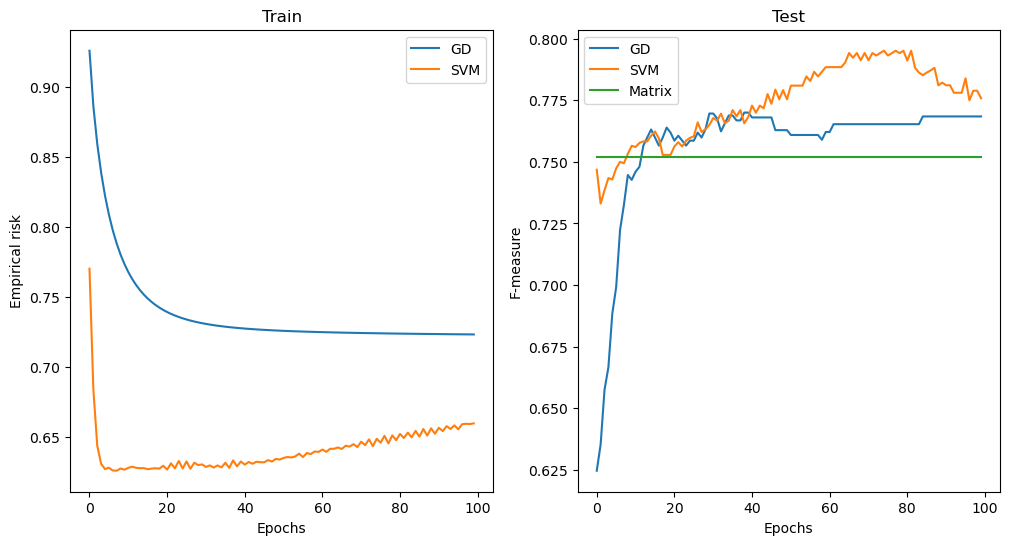

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('Train')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Empirical risk')
ax[0].plot(gd_classifier.train_history, label='GD')
ax[0].plot(svm_classifier.train_history, label='SVM')
ax[0].legend()

ax[1].set_title('Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('F-measure')
ax[1].plot(gd_classifier.test_history, label='GD')
ax[1].plot(svm_classifier.test_history, label='SVM')
ax[1].plot(matrix_test, label='Matrix')
ax[1].legend()

# Библиотечные реализации

## Подбор гиперпараметров

In [16]:
from sklearn.linear_model import ElasticNet

def en_objective(trial):
    alpha = trial.suggest_float('alpha', 1e-2, 1, log=True)
    l1 = trial.suggest_float('l1', 1e-2, 1, log=True)
    classifier = ElasticNet(alpha=alpha, l1_ratio=l1)
    classifier.fit(train_data, train_target)
    prediction = classifier.predict(valid_data)
    return f1_score(valid_target, np.array([1 if prediction[i] >= 0 else -1 for i in range(len(prediction))]))

study = optuna.create_study(direction='maximize')
study.optimize(en_objective, n_trials=100)
print(study.best_params)

[I 2024-04-05 13:11:31,394] A new study created in memory with name: no-name-324436db-6fe6-4aee-8a79-01d53e42a9a7
[I 2024-04-05 13:11:31,409] Trial 0 finished with value: 0.7532467532467533 and parameters: {'alpha': 0.18320680518372567, 'l1': 0.11937947422394496}. Best is trial 0 with value: 0.7532467532467533.
[I 2024-04-05 13:11:31,416] Trial 1 finished with value: 0.7628205128205128 and parameters: {'alpha': 0.05014654189241321, 'l1': 0.6932914623120492}. Best is trial 1 with value: 0.7628205128205128.
[I 2024-04-05 13:11:31,431] Trial 2 finished with value: 0.7612903225806451 and parameters: {'alpha': 0.02726231211758159, 'l1': 0.6977698620479198}. Best is trial 1 with value: 0.7628205128205128.
[I 2024-04-05 13:11:31,431] Trial 3 finished with value: 0.7652733118971061 and parameters: {'alpha': 0.05467308861510243, 'l1': 0.15791653413866927}. Best is trial 3 with value: 0.7652733118971061.
[I 2024-04-05 13:11:31,447] Trial 4 finished with value: 0.7717041800643086 and parameters: 

{'alpha': 0.01847004989444086, 'l1': 0.11758838263772088}


In [18]:
from sklearn.svm import SVC

def svc_objective(trial):
    c = trial.suggest_float('C', 1e-2, 1e2, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    degree, coef0 = 1, 0
    if kernel == 'poly':
        degree = trial.suggest_int('degree', 1, 3)
        coef0 = trial.suggest_float('coef0', 0, 2)
    if kernel == 'sigmoid':
        coef0 = trial.suggest_float('coef0', 0, 2)
    classifier = SVC(C=c, kernel=kernel, degree=degree, coef0=coef0)
    classifier.fit(train_data, train_target)
    return f1_score(valid_target, classifier.predict(valid_data))

study = optuna.create_study(direction='maximize')
study.optimize(svc_objective, n_trials=100)
print(study.best_params)

[I 2024-04-05 13:16:55,429] A new study created in memory with name: no-name-e8c2018c-ebd6-4108-887f-9428baca4fbf
[I 2024-04-05 13:16:55,527] Trial 0 finished with value: 0.7643312101910829 and parameters: {'C': 0.4866210972505578, 'kernel': 'rbf'}. Best is trial 0 with value: 0.7643312101910829.
[I 2024-04-05 13:16:56,515] Trial 1 finished with value: 0.7534246575342466 and parameters: {'C': 33.23556444998567, 'kernel': 'linear'}. Best is trial 0 with value: 0.7643312101910829.
[I 2024-04-05 13:16:56,600] Trial 2 finished with value: 0.7643312101910829 and parameters: {'C': 0.49434233278277395, 'kernel': 'rbf'}. Best is trial 0 with value: 0.7643312101910829.
[I 2024-04-05 13:16:56,700] Trial 3 finished with value: 0.5647840531561462 and parameters: {'C': 0.313551987902415, 'kernel': 'sigmoid', 'coef0': 1.7493451396022095}. Best is trial 0 with value: 0.7643312101910829.
[I 2024-04-05 13:16:56,747] Trial 4 finished with value: 0.5421686746987951 and parameters: {'C': 12.16203761616088

{'C': 64.55365696937157, 'kernel': 'rbf'}


## Кривые обучения

In [43]:
en_classifier = ElasticNet(alpha=0.0185, l1_ratio=0.1176)
en_classifier.fit(X_train, y_train)
prediction = en_classifier.predict(X_test)
en_result = f1_score(y_test, np.array([1 if prediction[i] >= 0 else -1 for i in range(len(prediction))]))

In [45]:
svc_classifier = SVC(C=64.55, kernel='rbf')
svc_classifier.fit(X_train, y_train)
svc_result = f1_score(y_test, svc_classifier.predict(X_test))

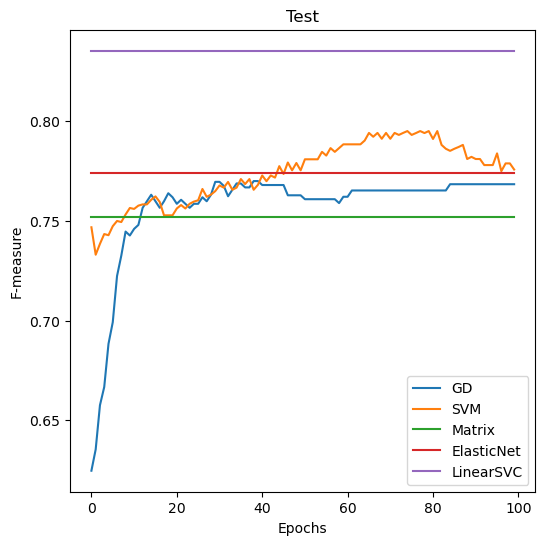

In [47]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.set_title('Test')
ax.set_xlabel('Epochs')
ax.set_ylabel('F-measure')
ax.plot(gd_classifier.test_history, label='GD')
ax.plot(svm_classifier.test_history, label='SVM')
ax.plot(matrix_test, label='Matrix')
ax.plot(np.full(100, en_result), label='ElasticNet')
ax.plot(np.full(100, svc_result), label='LinearSVC')
ax.legend()

# Сравнение коэффициентов

## My Gradient Descent & sklearn ElasticNet

In [82]:
from sklearn.metrics import mean_squared_error

gd_factors = pd.Series(gd_classifier.w, name='GD')
en_factors = pd.Series(en_classifier.sparse_coef_.toarray().flatten(), index=gd_classifier.w.index, name='ElasticNet')
print(pd.DataFrame([gd_factors, en_factors]).transpose())
print('MSE: ', mean_squared_error(gd_classifier.w, en_classifier.sparse_coef_.toarray().flatten()))

                             GD  ElasticNet
Population             0.010785   -0.077989
Asian                  0.044108    0.043282
White                  0.037317    0.024349
Black                  0.119622    0.111667
Indian                -0.042272   -0.040199
Hispanic               0.067060    0.074471
Hawaiian              -0.145367   -0.142861
Other                  0.003181   -0.006814
Females                0.079979    0.217540
Males                  0.040241    0.000000
Median_age             0.031155    0.053720
Median_female_age      0.073597    0.080448
Median_male_age       -0.052192   -0.085191
Households             0.059524    0.061431
Persons_per_household  0.086017    0.084421
Household_income      -0.183037   -0.178013
Total_area             0.078308    0.071066
Land_area              0.080933    0.084932
Water_area            -0.010208   -0.006663
Elevation             -0.298578   -0.294038
Density               -0.117375   -0.116980
MSE:  0.001457105815240848


## My SVM & sklearn SVC 

In [80]:
svc_classifier.support_vectors_

array([[ 0.44790676, -0.26089192,  0.43573446, ..., -0.24244464,
        -0.56877205,  0.78190419],
       [-0.59531338, -0.34720535, -0.46597468, ..., -0.24244464,
         0.06949114, -0.24466743],
       [-0.81237405, -0.33761496, -0.82929509, ..., -0.24244464,
         1.0571945 ,  0.21148216],
       ...,
       [ 0.65832271,  0.12272331,  0.71811261, ..., -0.24244464,
        -0.30847477,  2.9384685 ],
       [ 0.94792151,  1.8585822 ,  0.87141236, ...,  2.22259171,
        -0.84689791,  0.96465392],
       [ 3.76306546,  1.68595535,  2.41667386, ...,  0.48345563,
        -0.77201787, -0.24556845]])

In [88]:
support_vectors = []
for i in range(X_train.shape[0]):
    m = np.dot(X_train.iloc[i], svm_classifier.w) * y_train.iloc[i]
    if 0.9 <= m <= 1.1:
        support_vectors.append(X_train.iloc[i])
np.asarray(support_vectors)

array([[-0.59531338, -0.34720535, -0.46597468, ..., -0.24244464,
         0.06949114, -0.24466743],
       [ 0.54120963, -0.10744583,  0.62981195, ..., -0.24244464,
        -0.20150329,  1.19695957],
       [-0.72460845, -0.32802458, -0.73884824, ...,  0.21124303,
         0.24064551, -1.13510716],
       ...,
       [-0.77915048, -0.28966306, -0.66281156, ..., -0.22732172,
        -0.64008637,  0.56867659],
       [ 0.5946442 ,  0.75568843,  0.55561487, ..., -0.24244464,
         0.13010831,  0.34679139],
       [ 0.5639124 ,  0.9187249 ,  0.62797235, ..., -0.24244464,
        -0.9110808 , -0.21724518]])